## Train an image classification model on the MNIST Handwritten Images dataset
In this tutorial, you train a machine learning model on YData and then deploy it on Azure.

This tutorial trains a simple logistic regression modelusing the [MNIST](https://azure.microsoft.com/services/open-datasets/catalog/mnist/) dataset and [scikit-learn](http://scikit-learn.org) with Azure Machine Learning.  MNIST is a popular dataset consisting of 70,000 grayscale images. Each image is a handwritten digit of 28x28 pixels, representing a number from 0 to 9. The goal is to create a multi-class classifier to identify the digit a given image represents. 

Learn how to:

> * Set up your development environment
> * Access and examine the data
> * Train and pickle a simple logistic regression model using YData
> * Review training results
> * Set up your testing environment on ACI
> * Retrieve the model from your workspace
> * Test the model locally
> * Deploy the model to ACI
> * Test the deployed model

## Set up your development environment

All the setup for your development work can be accomplished in a Python notebook.  Setup includes:

* Importing Python packages
* Connecting to a workspace to enable communication between your local computer and remote resources
* Creating a remote compute target to use for training

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [23]:
!pip install azureml-sdk scikit-learn==0.22.1 pandas numpy matplotlib

### Connect to workspace

Download your Azure Workspace configuration file and upload it in this working directory - It will be used to remotely access your Azure Workspace from your Jupyter notebook instance

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`.

In [24]:
from azureml.core import Workspace
ws_other_environment = Workspace.from_config(path="./config.json")

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.34.0


### Load workspace configuration from the config.json file in the current folder

In [26]:
ws = ws_other_environment
print(ws.name, ws.location, ws.resource_group, sep='\t')

azureml-demo	eastus2	demo


### Load data

Load the test data from the **./data/mnist** directory

In [27]:
import numpy as np
import argparse
import os
from sklearn.linear_model import LogisticRegression
import joblib

from azureml.core import Run

import gzip
import numpy as np
import struct


# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


data_folder = os.path.join(os.getcwd(), 'data/mnist')

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data("{}/train-images-idx3-ubyte.gz".format(data_folder), False) / 255.0
X_test = load_data("{}/t10k-images-idx3-ubyte.gz".format(data_folder), False) / 255.0
y_train = load_data("{}/train-labels-idx1-ubyte.gz".format(data_folder), True).reshape(-1)
y_test = load_data("{}/t10k-labels-idx1-ubyte.gz".format(data_folder), True).reshape(-1)
print("X_train Shape: {}\ny_train Shape: {}\nX_test Shape: {}\ny_test Shape: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))


X_train Shape: (60000, 784)
y_train Shape: (60000,)
X_test Shape: (10000, 784)
y_test Shape: (10000,)


### Display some sample images

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them. Note this step requires a `load_data` function that's included in an `utils.py` file. This file is included in the sample folder. Please make sure it is placed in the same folder as this notebook. The `load_data` function simply parses the compresse files into numpy arrays.

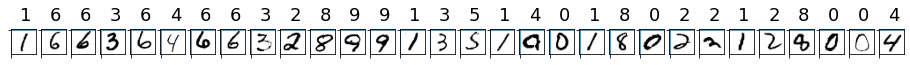

In [28]:
# make sure utils.py is in the same directory as this code
# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

## Train the Logistic Regression Model

In [29]:
print('Train a logistic regression model with regularization rate of', 0.5)
clf = LogisticRegression(C=1.0/0.5, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

Train a logistic regression model with regularization rate of 0.5
Predict the test set
Accuracy is 0.9193


### Package (pickle) and save the model

In [30]:
joblib.dump(value=clf, filename='./sklearn_mnist_model.pkl')

['./sklearn_mnist_model.pkl']